<a href="https://colab.research.google.com/github/andrew-gerlach/small-world-hippos/blob/Kathleen2/load_chp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Necessary for visualization
!pip install nilearn --quiet
from nilearn import plotting, datasets

     |████████████████████████████████| 4.9MB 5.9MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [3]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [4]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [5]:
fname = "hcp_rest.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/bqp7m/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [6]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [7]:
fname = "hcp_covariates.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/x5p4g/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [8]:
fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [9]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

unique_networks = np.unique(region_info['network'])
network_regions = {}
for network in unique_networks:
  regions = []
  for j in range(len(region_info['name'])):
    if region_info['network'][j] == network:
      regions.append(region_info['name'][j])
  network_regions[network] = regions

We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [10]:
with np.load(f"{HCP_DIR}/atlas.npz") as dobj:
  atlas = dict(**dobj)

# Helper functions


## Data loading

In [11]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

## Task-based analysis

In [12]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Resting-state analyses

Load a single run of resting-state data:

In [13]:
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



In [14]:
timeseries = load_timeseries(subject=0, name="rest", runs=1)
print(timeseries.shape)  # n_parcel x n_timepoint

(360, 1200)


Load a concatenated resting-state timeseries (using all runs' data) for each subject:

In [15]:
timeseries_rest = []
for subject in subjects:
  ts_concat = load_timeseries(subject, "rest")
  timeseries_rest.append(ts_concat)

## Run a simple correlation-based "functional connectivity" analysis

Generate a correlation matrix (showing "functional connectivity" or FC) for each subject and plot the group average:

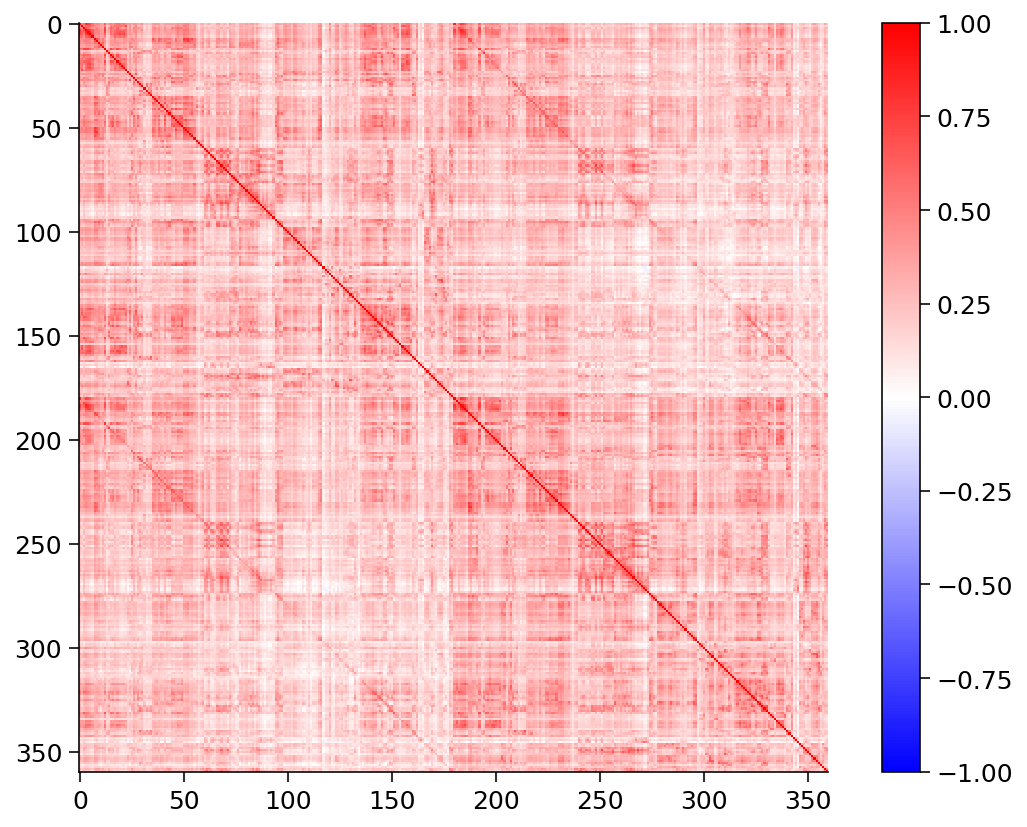

In [16]:
fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_rest):
  fc[sub] = np.corrcoef(ts)

group_fc = fc.mean(axis=0)

plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

Plot the profile of FC values between a particular "seed" parcel and every parcel in the dataset, separated by hemisphere:

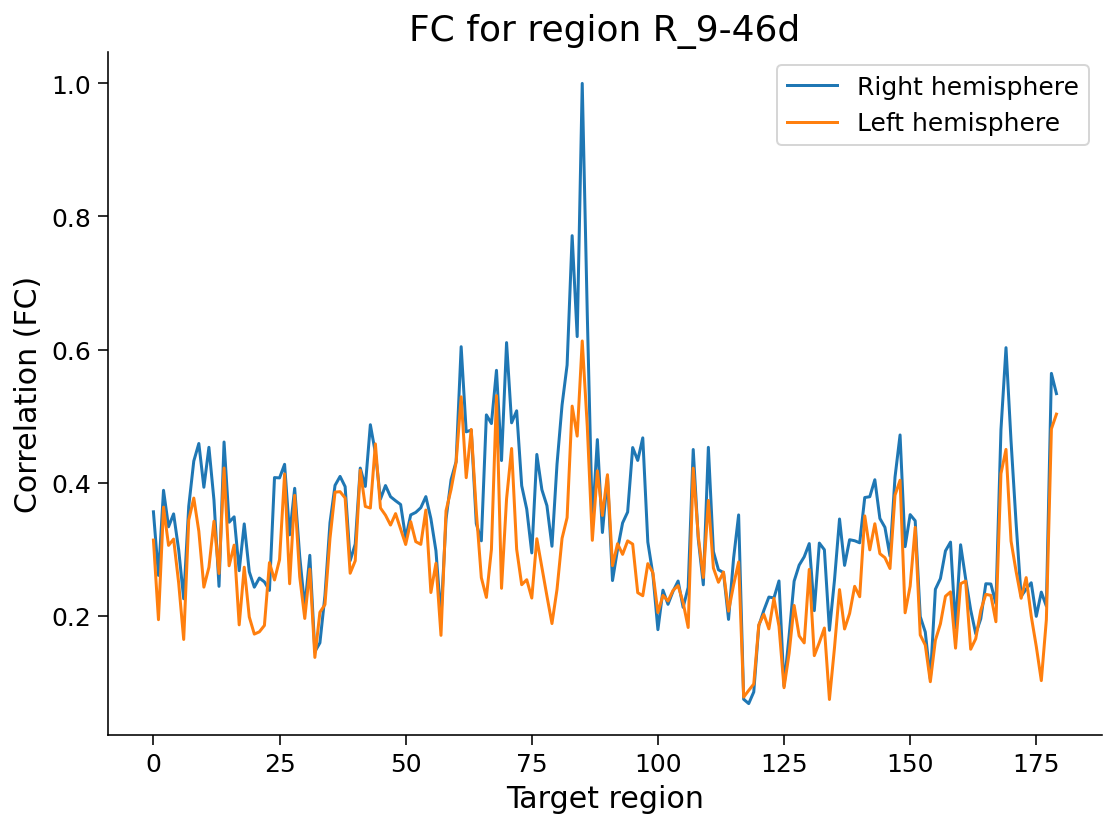

In [17]:
seed_roi = "R_9-46d"  # name of seed parcel
seed_idx = region_info["name"].index(seed_roi)

hemi_fc = np.split(group_fc, 2)

# Plot the FC profile across the right and left hemisphere target regions
for i, hemi_fc in enumerate(hemi_fc):
  plt.plot(hemi_fc[:, seed_idx], label=f"{HEMIS[i]} hemisphere")
plt.title(f"FC for region {seed_roi}")
plt.xlabel("Target region")
plt.ylabel("Correlation (FC)")
plt.legend()
plt.show()

Threshold the correlation matrix to produce a connectome, and plot it:

In [18]:
plotting.view_connectome(group_fc, atlas["coords"], edge_threshold="99%")

ACTUAL PROJECT WORK
Calculate the node-wise functional connectivity summary features

In [102]:
#Delete subjects missing behavioral data: 81, 143, 339
fc1 = np.delete(fc, 80,0)
fc2 = np.delete(fc1, 141,0)
fc3 = np.delete(fc2, 336,0)
dlpfc_all = np.zeros((336,1))

#Add an roi that is the sum of all dlpfc regions
dlpfc_areas = ["L_9-46d", "L_8C", "L_8Av", "L_i6-8", "L_s6-8", "L_SFL", "L_8BL", "L_9p", "L_9a", "L_8Ad", "L_p9-46v", "L_a9-46v", "L_46"] 
seed_idx = region_info["name"].index(seed_roi)
dlpfc_all = np.zeros((N_SUBJECTS, len(dlpfc_areas), N_PARCELS))
#print(fc[:,seed_idx,:])
for area in range(len(dlpfc_areas)):
  seed_idx = region_info["name"].index(dlpfc_areas[area])
  for i_subj in range(N_SUBJECTS):
    dlpfc_all[i_subj, area, :]= fc[i_subj, seed_idx,:]
dlpfc_sum = np.sum(dlpfc_all, axis=1) #array 336x360 of sum of activity for all dlpfc areas (subjectsxtargets) 
#do the dimensions of dlpfc_sum align with fc3 array? Does the dstack make sense? 
print(np.dstack((fc3, dlpfc_sum)).shape)

print(fc3.shape)
#print(network_regions['Posterior-Mu'])


# Node-to-node connectivity
N_SUBJECTS=336
def extract_connectivities(seed_rois, target_rois, fc, nSubj):
  fc_summary = np.zeros((N_SUBJECTS,len(seed_rois),len(target_rois)))
  for i_seed in range(len(seed_rois)):
    if seed_rois[i_seed]=="dlpfc":
      seed_idx=360
    else:
      seed_idx = region_info["name"].index(seed_rois[i_seed])
    for i_target in range(len(target_rois)):
      target_idx = region_info["name"].index(target_rois[i_target])
      if target_idx == seed_idx:
        continue 
      for i_subj in range(nSubj):
        fc_summary[i_subj,i_seed,i_target] = fc[i_subj,seed_idx,target_idx]

  return fc_summary
#returns matrix correlations between seed and target with dimensions (subjects, seed_rois, target_rois)

# example to calculate right dlPFC to DAN
seed_rois = ["L_9-46d"]
target_rois = network_regions['Dorsal-atten']
fc_n2n = extract_connectivities(seed_rois, target_rois, fc3, N_SUBJECTS) 
fc_dlPFC_to_DAN = fc_n2n.mean(axis=2)    # average over all target nodes

#example for multiple of seeds
seed_rois =  network_regions['Default']
fc_n2n_list = extract_connectivities(seed_rois, target_rois, fc3, N_SUBJECTS)
fc_default_to_DAN = fc_n2n_list.mean(axis=2)    # average over all target nodes
#fc_default_to_DAN #matrix of average correlations of each DMN node with all of DAN combined. Dimensions are (n_subjects, # of DMN nodes)

### Create dataframes for left DLPFc n2n and n2net during resting state ###### 
#left DLPFc to nodes in Cingulo-opercular
seed_rois = ["L_9-46d"]
target_rois = network_regions['Cingulo-Oper']
rs_fc_n2n_dlPFC_within = extract_connectivities(seed_rois, target_rois, fc3, N_SUBJECTS) #array with correlations of dlpfs with each node in CO for each subject
 
#left DLPFC to overall within network connectivity (cingulo-operc)
rs_fc_dlPFC_CO = rs_fc_n2n_dlPFC_within.mean(axis=2)    # mean of correlations to all other nodes within-network

#left DLPFC to overall Fronto-parietal
fc_n2net_dlPFC_FP = extract_connectivities(seed_rois, network_regions['Frontopariet'], fc3, N_SUBJECTS)
rs_fc_dlPFC_FP = fc_n2net_dlPFC_FP.mean(axis=2)

#left DLPFC to overall DAN
fc_n2net_dlPFC_DAN = extract_connectivities(seed_rois, network_regions['Dorsal-atten'], fc3, N_SUBJECTS)
rs_fc_dlPFC_DAN = fc_n2net_dlPFC_DAN.mean(axis=2)

##left DLPFC to overall DMN
fc_n2net_dlPFC_DMN = extract_connectivities(seed_rois, network_regions['Default'], fc3, N_SUBJECTS)
rs_fc_dlPFC_DMN = fc_n2net_dlPFC_DMN.mean(axis=2)




(336, 360, 361)
(336, 360, 360)


IndexError: ignored

In [101]:
#test 
dlpfc_areas = ["L_9-46d", "L_8C", "L_8Av", "L_i6-8", "L_s6-8", "L_SFL", "L_8BL", "L_9p", "L_9a", "L_8Ad", "L_p9-46v", "L_a9-46v", "L_46"] 
dlpfc_all = np.zeros((N_SUBJECTS, len(dlpfc_areas), N_PARCELS))
#print(fc[:,seed_idx,:])

for area in range(len(dlpfc_areas)):
  seed_idx = region_info["name"].index(dlpfc_areas[area])
  for i_subj in range(N_SUBJECTS):
    dlpfc_all[i_subj, area, :]= fc[i_subj, seed_idx,:]
dlpfc_sum = np.sum(dlpfc_all, axis=1)

fc[0]
#print(network_regions['Posterior-Mu'])

(336, 360, 361)
(336, 360)


# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools, 
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

## Load individual runs for a given task

Load each subject's data for a specific task, separately for each run:

In [21]:
timeseries_task = []
for subject in subjects:
  timeseries_task.append(load_timeseries(subject, "motor", concat=False))

## Run a simple subtraction analysis

In [ ]:
help(load_evs)

In [ ]:
help(selective_average)

In [22]:
task = "motor"
conditions = ["lf", "rf"]  # Run a substraction analysis between two conditions

contrast = []
for subject in subjects:

  # Get the average signal in each region for each condition
  evs = [load_evs(subject, task, cond) for cond in conditions]
  avgs = [selective_average(timeseries_task[subject], ev) for ev in evs]

  # Store the region-wise difference
  contrast.append(avgs[0] - avgs[1])

group_contrast = np.mean(contrast, axis=0)

Plot group-averaged contrast value across regions:

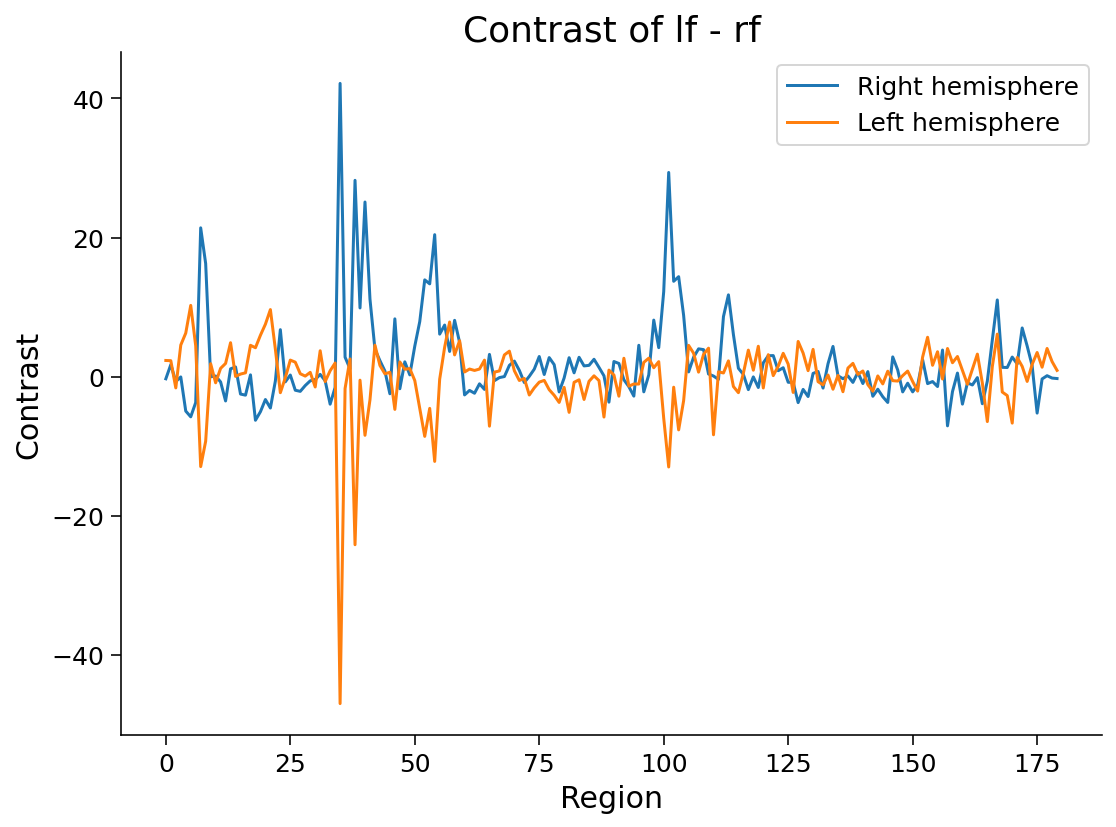

In [23]:
hemi_contrasts = np.split(group_contrast, 2)

for i, hemi_contrast in enumerate(hemi_contrasts):
  plt.plot(hemi_contrast, label=f"{HEMIS[i]} hemisphere")

plt.title("Contrast of %s - %s" % (conditions[0], conditions[1]))
plt.xlabel("Region")
plt.ylabel('Contrast')
plt.legend()
plt.show()

Plot the regional values on the surface of one hemisphere:

In [24]:
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=15)

## Characterize values by functional network

Average the contrast values within parcels belonging to each network and plot:

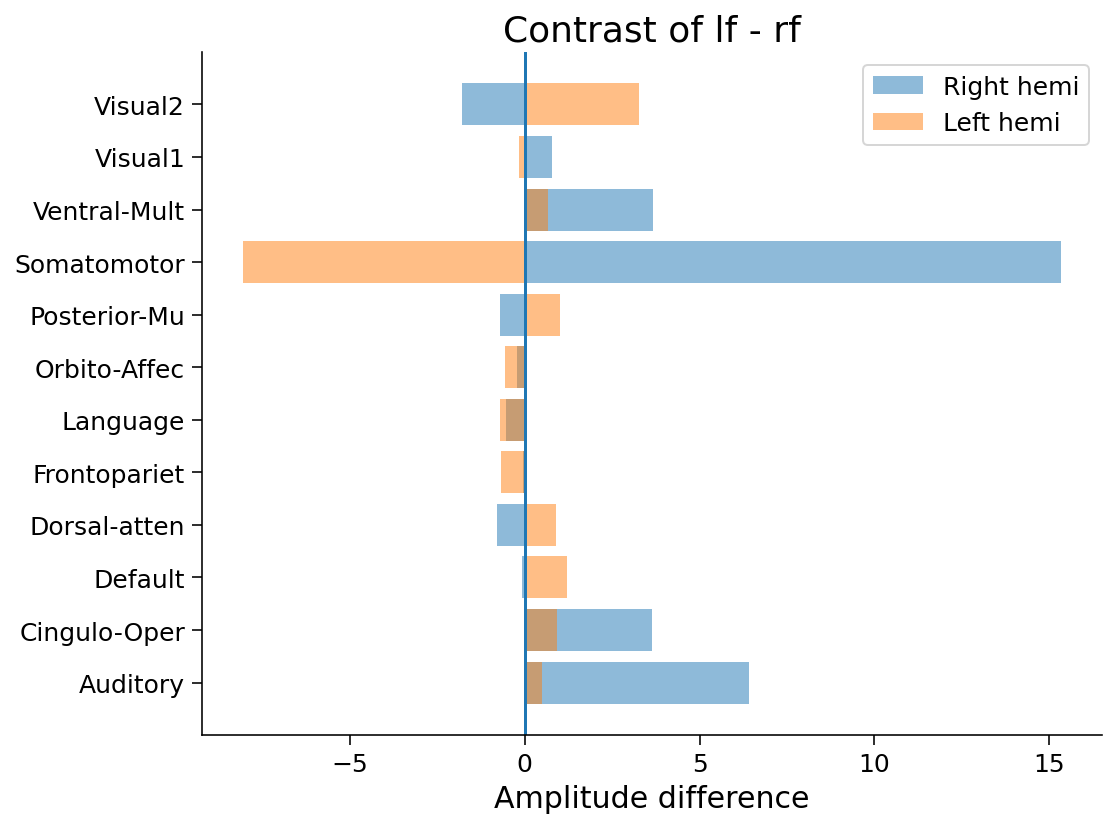

In [25]:
# Get unique network labels
network_names = np.unique(region_info["network"])

hemi_networks = np.split(region_info["network"], 2)
hemi_contrasts = np.split(group_contrast, 2)

# Get and plot mean contrast value per network, by hemisphere
for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_networks, hemi_contrasts):
  network_vals = []
  for network in network_names:
    network_vals.append(hemi_contrast[hemi_network == network].mean())
  plt.barh(network_names, network_vals, alpha=.5, label=f"{hemi} hemi")

plt.axvline(0)
plt.xlabel("Amplitude difference")
plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
plt.legend()
plt.show()

# Behavioral covariates


## Task performance measures

The dataset also includes aggregate behavior for each task run stored in task-specific `.csv` files. It is possible to load and work with these files using `numpy`:

         Run     ACC  ...  MEDIAN_RT_NONTARGET  MEDIAN_RT_TARGET
Subject               ...                                       
0        0.5  1.0000  ...             866.9375        850.625000
1        0.5  1.0000  ...             523.8125        604.937500
2        0.5  0.9875  ...             565.0000        725.937500
3        0.5  0.9750  ...             711.8750        815.875000
4        0.5  0.6750  ...             859.6875        951.666667
...      ...     ...  ...                  ...               ...
333      0.5  0.9750  ...             642.3750        695.875000
334      0.5  0.7125  ...             555.8125        793.500000
335      0.5  0.9250  ...             759.5625        807.500000
336      0.5  0.9500  ...             682.5000        864.437500
337      0.5  0.8875  ...             926.3125        836.083333

[336 rows x 7 columns]
0 back Accuracy; mean SD
0.93 0.09
2 back Accuracy; mean SD
0.85 0.09
0 back MEDIAN_RT; mean SD
751.86 152.23
2 back MEDIAN_RT; mea

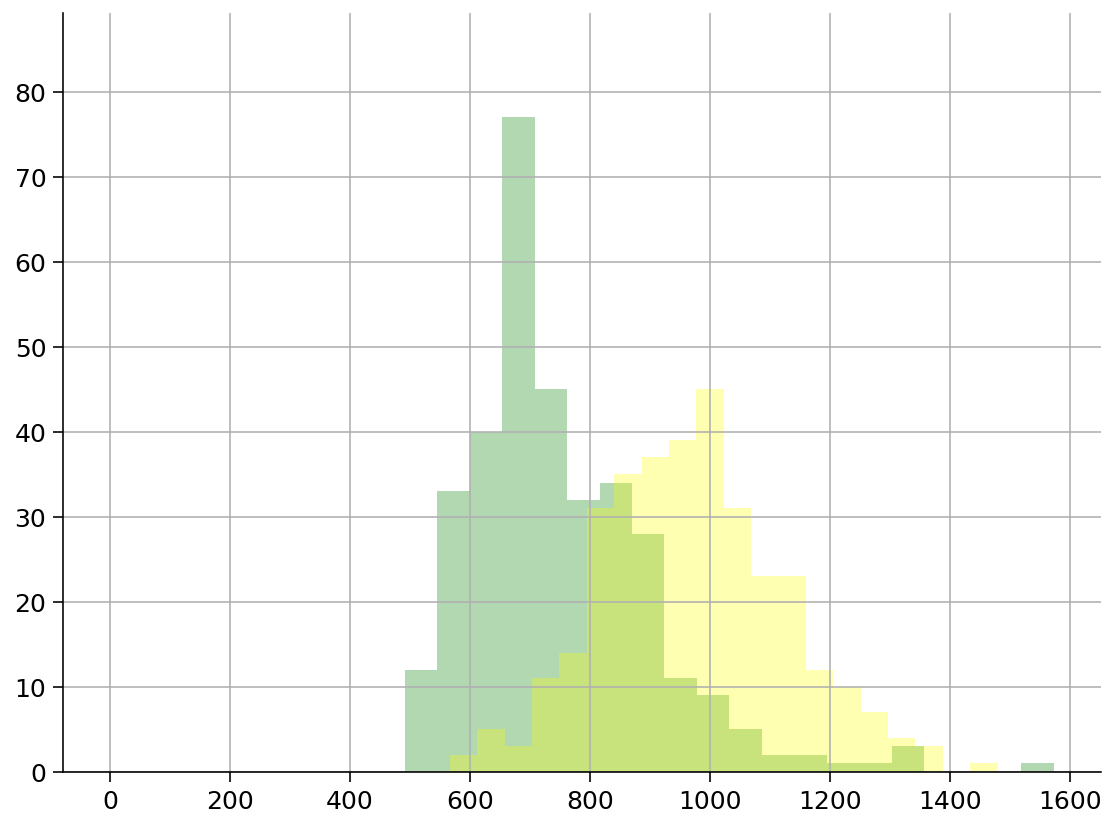

In [28]:
import pandas as  pd

wm_behavior = np.genfromtxt("hcp/behavior/wm.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
#print(wm_behavior[:5])
#print(wm_behavior.dtype.names)

# Make separate dataframes for 0 and 2 back performance measures
back0_array = (wm_behavior[np.where((wm_behavior["ConditionName"] == "0BK_BODY") | (wm_behavior["ConditionName"] == "0BK_FACE") | (wm_behavior["ConditionName"] == "0BK_TOOL") | (wm_behavior["ConditionName"] == "0BK_PLACE"))])
back2_array = (wm_behavior[np.where((wm_behavior["ConditionName"] == "2BK_BODY") | (wm_behavior["ConditionName"] == "2BK_FACE") | (wm_behavior["ConditionName"] == "2BK_TOOL") | (wm_behavior["ConditionName"] == "2BK_PLACE"))])

#remove missing subjects
back0_df = pd.DataFrame(back0_array)
back2_df = pd.DataFrame(back2_array)
#print(back0_array3.shape)

# Make dataframes with 1 performance score per subject (averaged across runs)
back0_mean = back0_df.groupby('Subject').mean()
back2_mean = back2_df.groupby('Subject').mean()

back0_mean1 = back0_mean.drop([80, 142, 338])
print(back0_mean1)
# Concat 0 and 2 back dataframes
wm_behavior_byBlock = pd.concat([back0_mean, back2_mean], keys=['0back', '2back'])

# Average by subject and run
#back0_df.groupby(['Subject', 'Run']).mean()
#back2_df.groupby(['Subject', 'Run']).mean()

# Accuracy Mean and standard deviation 
print("0 back Accuracy; mean SD")
print(round(back0_mean["ACC"].mean(), 2), round(back0_mean["ACC"].std(),2 ))
print("2 back Accuracy; mean SD")
print(round(back2_mean["ACC"].mean(),2), round(back2_mean["ACC"].std(),2))

# RT Mean and standard deviation 
print("0 back MEDIAN_RT; mean SD")
print(round(back0_mean["MEDIAN_RT"].mean(), 2), round(back0_mean["MEDIAN_RT"].std(),2 ))
print("2 back MEDIAN_RT; mean SD")
print(round(back2_mean["MEDIAN_RT"].mean(), 2), round(back2_mean["MEDIAN_RT"].std(),2 ))

# Histograms
#back0_mean.hist(bins=20)
#back2_mean.hist(bins=20)
hist_acc_0 = back0_mean["ACC"].hist(bins=20, color = "blue", alpha=0.3)
hist_acc_2 = back2_mean["ACC"].hist(bins=20, color = "red", alpha=0.3)

hist_rt_0 = back0_mean["MEDIAN_RT"].hist(bins=20, color = "green", alpha=0.3)
hist_rt_2 = back2_mean["MEDIAN_RT"].hist(bins=20, color = "yellow", alpha=0.3)




But, while not formally taught as part of the course, [`pandas`](https://pandas.pydata.org/) offers more powerful tools for tabular data analysis.

## Linear Regrssion Models in Resting State Data

DLPFC to Within Network Connectivity (Cingulo-opercular)

[63.11650179]


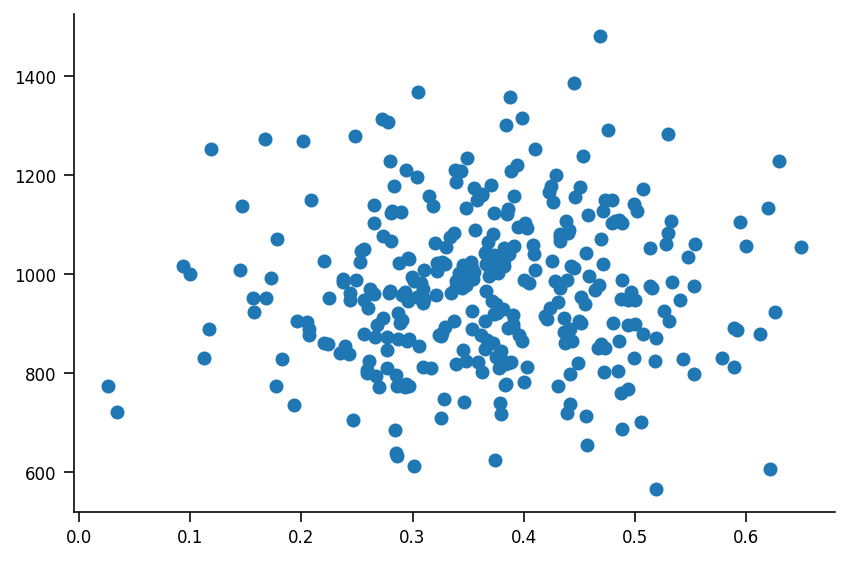

In [34]:
## Check rs data with regression models 
##Missing subjects: 81, 143, 339
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline
#Median RT
x= rs_fc_dlPFC_CO
y= back2_mean['MEDIAN_RT']
model = LinearRegression(normalize=True).fit(x, y)
print(model.coef_)
plt.scatter(x,y) 
plt.show()

[-0.02183998]


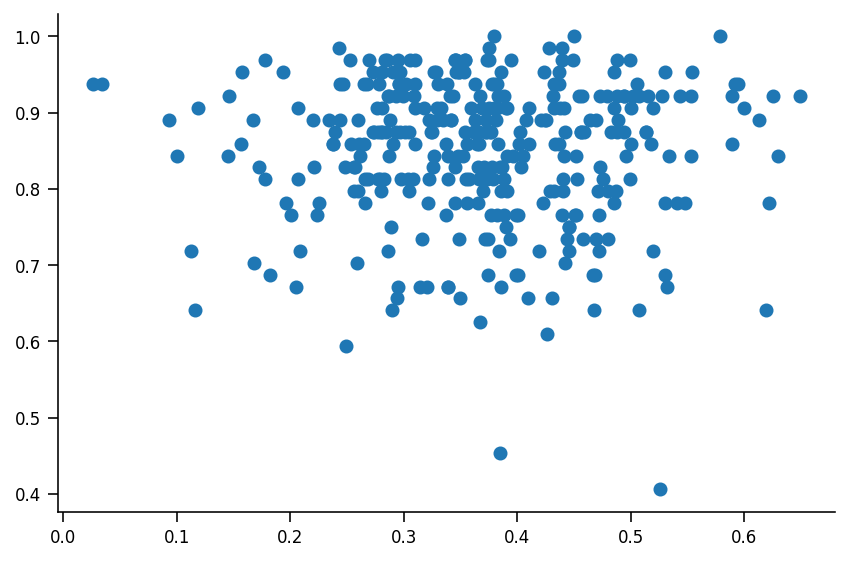

In [35]:
#Accuracy
x= rs_fc_dlPFC_CO
y= back2_mean['ACC']
#print(back2_df['Subject'].unique())
model = LinearRegression(normalize=True).fit(x, y)
print(model.coef_)
plt.scatter(x,y) 
plt.show()

DLPFC to Other Networks

[79.17529316]


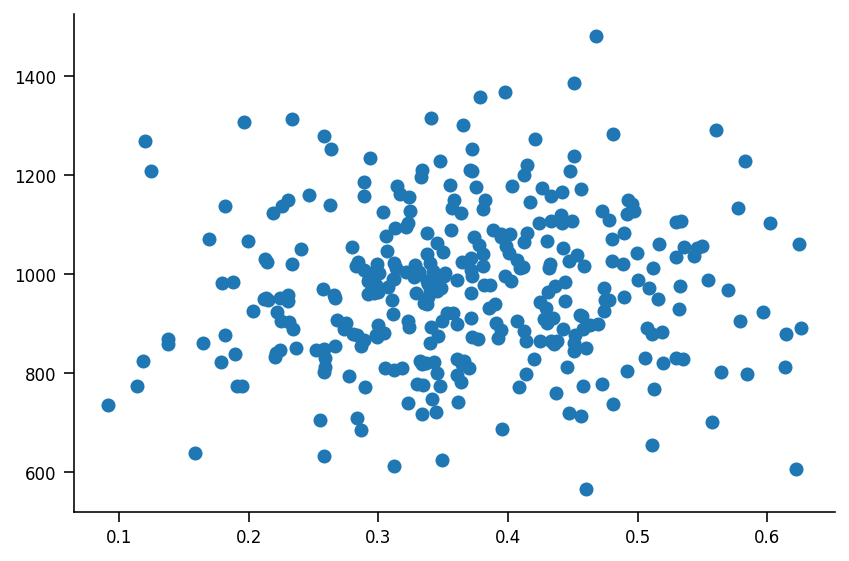

In [36]:
#dlpfc to FP RT
x= rs_fc_dlPFC_FP
y= back2_mean['MEDIAN_RT']
model = LinearRegression(normalize=True).fit(x, y)
print(model.coef_)
plt.scatter(x,y) 
plt.show()

[-0.05563164]


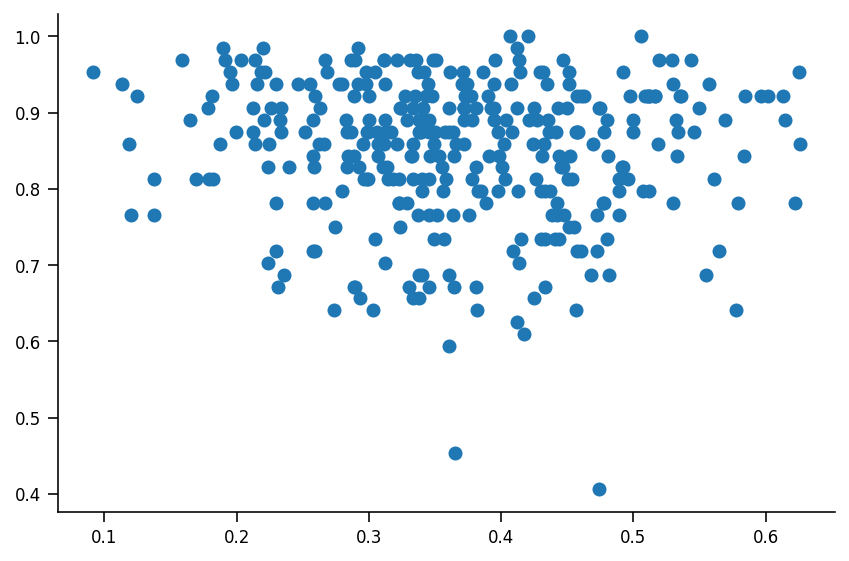

In [37]:
#dlpfc to FP Accuracy
x= rs_fc_dlPFC_FP
y= back2_mean['ACC']
model = LinearRegression(normalize=True).fit(x, y)
print(model.coef_)
plt.scatter(x,y) 
plt.show()

[124.1832661]


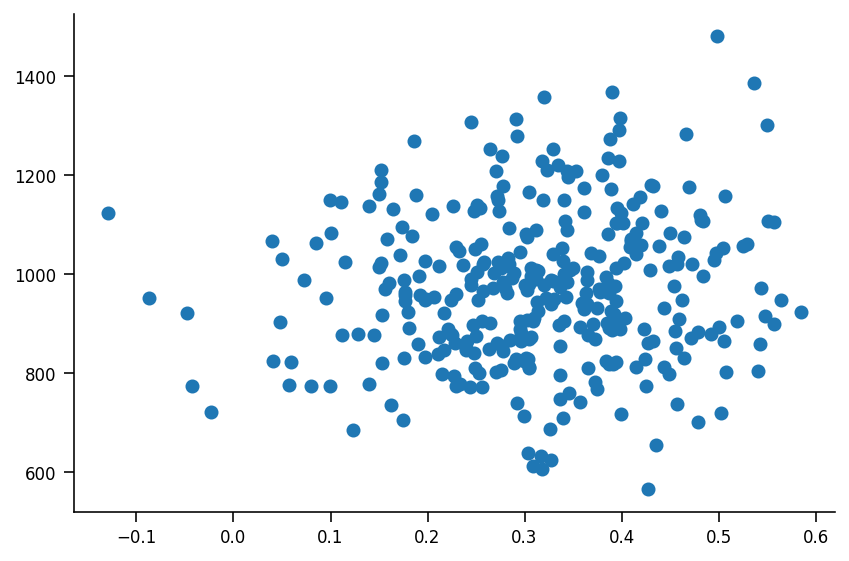

In [38]:
# DLPFC to DAN RT
x= rs_fc_dlPFC_DAN
y= back2_mean['MEDIAN_RT']
#print(back2_df['Subject'].unique())
model = LinearRegression(normalize=True).fit(x, y)
print(model.coef_)
plt.scatter(x,y) 
plt.show()

[-0.05563164]


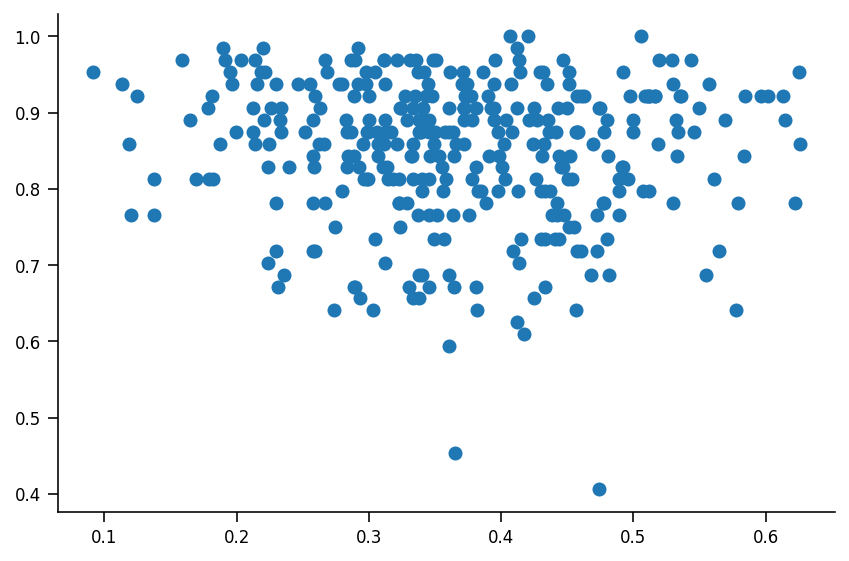

In [40]:
#dlpfc to FP ACC
x= rs_fc_dlPFC_FP
y= back2_mean['ACC']
model = LinearRegression(normalize=True).fit(x, y)
print(model.coef_)
plt.scatter(x,y) 
plt.show()

[89.4160145]


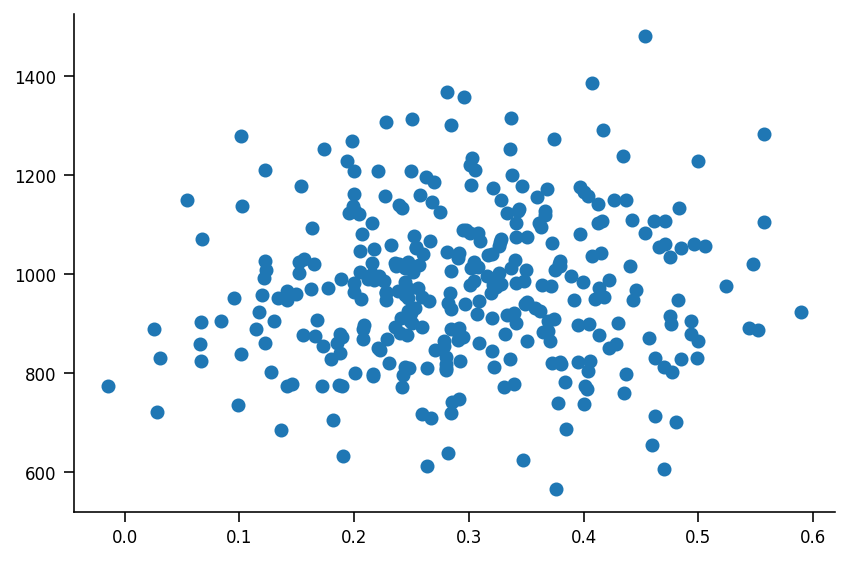

In [44]:
#dlpfc to DMN RT
x= rs_fc_dlPFC_DMN
y= back2_mean['MEDIAN_RT']
model = LinearRegression(normalize=True).fit(x, y)
print(model.coef_)
plt.scatter(x,y) 
plt.show()

[0.01493137]


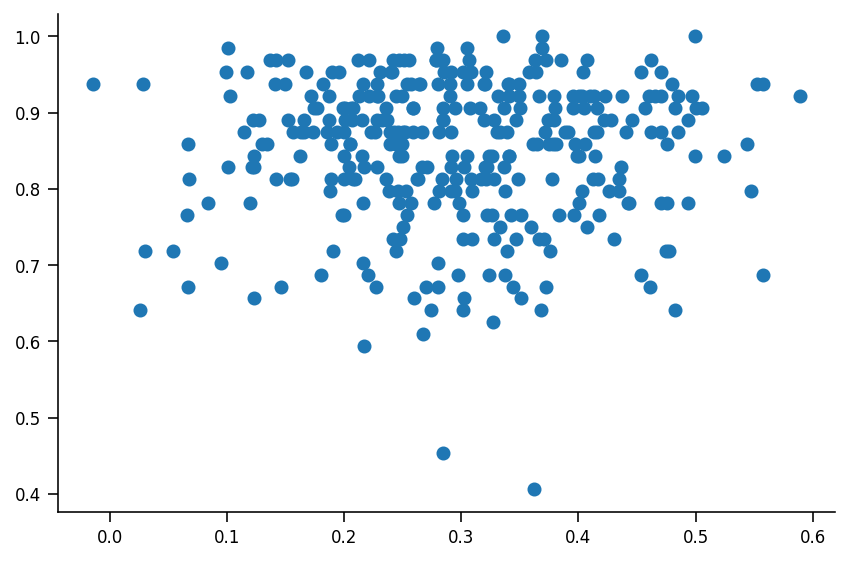

In [45]:
#dlpfc to DMN ACC
x= rs_fc_dlPFC_DMN
y= back2_mean['ACC']
model = LinearRegression(normalize=True).fit(x, y)
print(model.coef_)
plt.scatter(x,y) 
plt.show()

Node to Network Adding 0bk behavior as Covariate


[[14.61196934  0.66172428]]


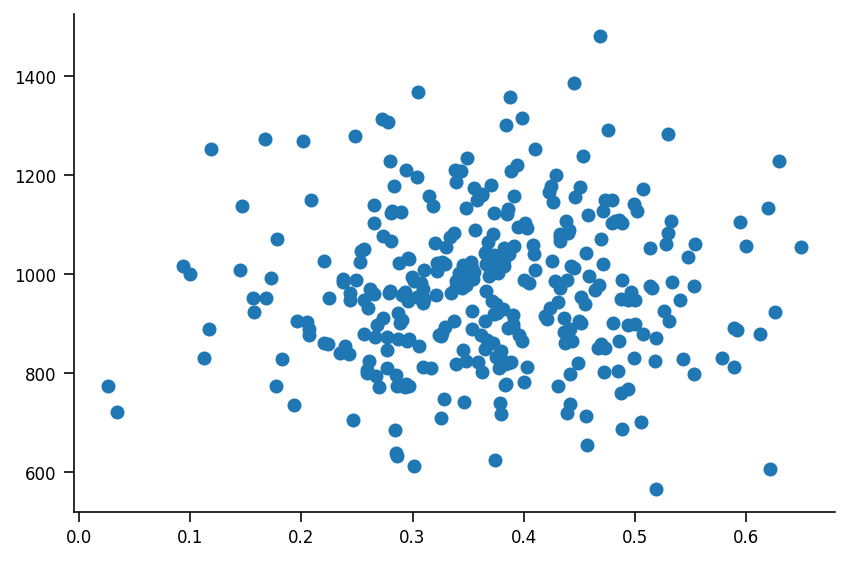

In [47]:
#add 0bk rt as covar Within Network
x1= rs_fc_dlPFC_CO
back0_array_clean= back0_mean.to_numpy()
x2=back0_array_clean[:,4]
x3 = x2[np.logical_not(np.isnan(x2))].reshape((336,1))
x= np.concatenate((x1, x3), axis=1)
y= back2_mean['MEDIAN_RT'].to_numpy().reshape((336,1))
model = LinearRegression().fit(x, y)
print(model.coef_)
plt.scatter(x[:,0],y) 
plt.show()


[[71.41688869  0.66185276]]


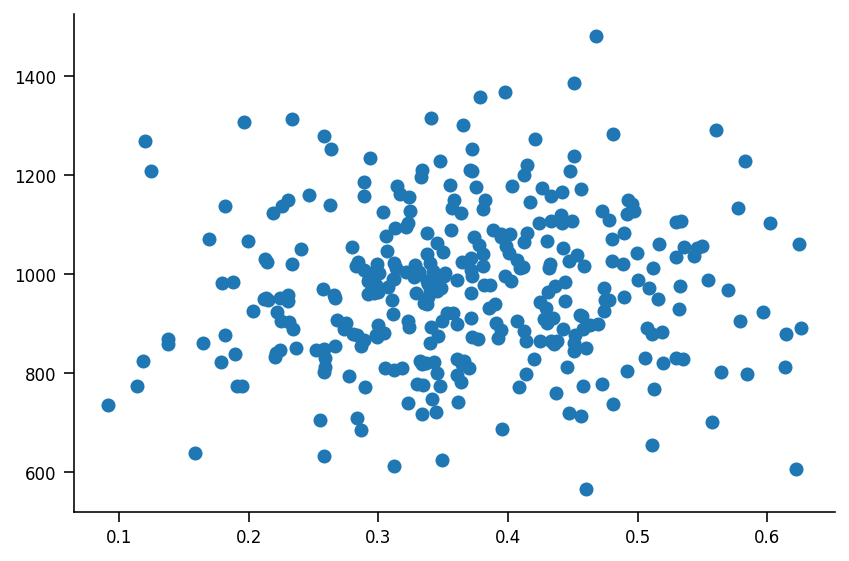

In [48]:
#FP
x1= rs_fc_dlPFC_FP
back0_array_clean= back0_mean.to_numpy()
x2=back0_array_clean[:,4]
x3 = x2[np.logical_not(np.isnan(x2))].reshape((336,1))
x= np.concatenate((x1, x3), axis=1)
y= back2_mean['MEDIAN_RT'].to_numpy().reshape((336,1))
model = LinearRegression().fit(x, y)
print(model.coef_)
plt.scatter(x[:,0],y) 
plt.show()


[[86.51315897  0.65908517]]


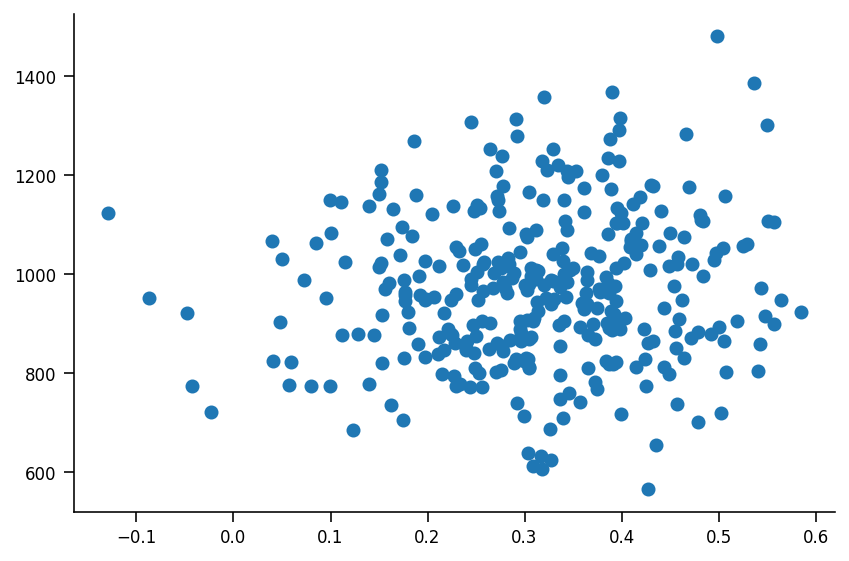

In [49]:
#DAN
x1= rs_fc_dlPFC_DAN
back0_array_clean= back0_mean.to_numpy()
x2=back0_array_clean[:,4]
x3 = x2[np.logical_not(np.isnan(x2))].reshape((336,1))
x= np.concatenate((x1, x3), axis=1)
y= back2_mean['MEDIAN_RT'].to_numpy().reshape((336,1))
model = LinearRegression().fit(x, y)
print(model.coef_)
plt.scatter(x[:,0],y) 
plt.show()


[[39.12483623  0.66064649]]


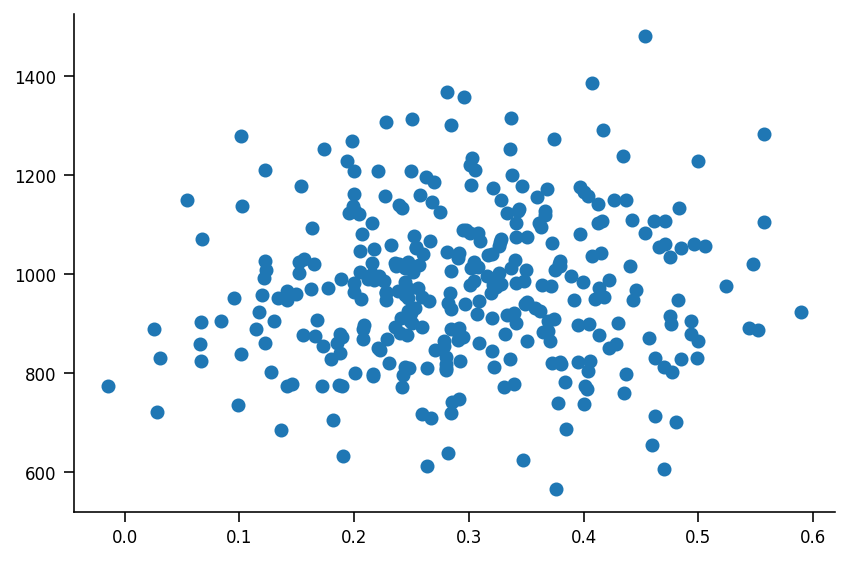

In [50]:
#DMN
x1= rs_fc_dlPFC_DMN
back0_array_clean= back0_mean.to_numpy()
x2=back0_array_clean[:,4]
x3 = x2[np.logical_not(np.isnan(x2))].reshape((336,1))
x= np.concatenate((x1, x3), axis=1)
y= back2_mean['MEDIAN_RT'].to_numpy().reshape((336,1))
model = LinearRegression().fit(x, y)
print(model.coef_)
plt.scatter(x[:,0],y) 
plt.show()

## Pseudo-demographics

The NMA-distributed version of the HCP data does not contain any real demographic information. But we have created a synthetic dataset of 25 "demographic" variables based on a model trained on the original dataset to predict demographics from resting-state network organization measures:

In [ ]:
demo = np.load("hcp/pseudo_demographics.npy")
demo.shape

## Original subject IDs

The dataset also contains a key to map the ordinal subject numbers to the IDs used in the original HCP dataset:

In [ ]:
ids = np.loadtxt("hcp/orig_ids.txt")
print(ids[:8])